In [1]:
import numpy as np
# from fetch_data import get_data, remove_cols
from helper import *
from getters_alpaca import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import requests

In [2]:
def get_data(coin: str, interval: str, limit: int):
    interval_int = {
        "1m": 60, "3m": 180, "5m": 300, "15m": 900, "30m": 1800,
        "1h": 3600, "2h": 7200, "4h": 14400, "6h": 21600, "8h": 28800,
        "12h": 43200, "1d": 86400, "3d": 259200, "1w": 604800, "1M": 2592000
    }[interval]
    
    start_time = int(time.time() * 1000) - (interval_int*1000 * limit )
    print(f"start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time/1000))}")
    data = pd.DataFrame()
    
    while True: 
        temp_data = get_data_from_timestamp(coin, interval, start_time, min(1000, limit))
        data = pd.concat([data, temp_data], ignore_index=True)
        
        if temp_data.empty:
            print("break")
            break
        
        start_time = temp_data.iloc[-1]['close_time'] + 1
        limit -= 1000
        
    return data


def get_data_from_timestamp(coin: str, interval: str, start_time: int, limit: int = 1000):
    url = "https://api.binance.com/api/v3/klines"

    params = {
        "symbol": coin, 
        "interval": interval,     
        "limit": limit, 
        "startTime": start_time
    }
    
    response = requests.get(url, params=params)
    data = response.json()

    df: pd.DataFrame = pd.DataFrame(data, columns=["timestamp", "open", "high", "low", "close", "volume", "close_time", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"])
    df.drop(columns=["ignore"], inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    return df

def remove_cols(data:pd.DataFrame, *args: str): 
    data.drop(columns=[*args], inplace=True)
    return data

In [3]:
coin_name = "LTCUSDT"
interval = "15m"
limit: int = 100000

from fetch_data import get_data, remove_cols
# get alpaca data
alpaca_data = get_data(coin_name, interval, limit)
alpaca_data = remove_cols(alpaca_data, "close_time", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume")
# turn it to np
alpaca_data = np.array(alpaca_data)


start time: 2021-07-26 06:56:00
break


In [4]:
# make series with usefull data
data = fill_data(alpaca_data)
#display_data_to_file(data, "working_data")
m, n = data.shape
np.random.shuffle(data)

In [5]:
data_train = data[:int(0.8*m)]
y_train = torch.tensor(data_train[:,0], dtype=torch.float32)
x_train = torch.tensor(data_train[:, 1:], dtype=torch.float32)

data_test = data[int(0.8*m):m]
y_test = torch.tensor(data_test[:,0], dtype=torch.float32)
x_test = torch.tensor(data_test[:, 1:], dtype=torch.float32)

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features=12, l1 = 10, l2=10):
        super().__init__()
        self.weights1 = nn.Parameter(torch.randn(in_features, l1, dtype=torch.float), requires_grad=True)
        self.bias1 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
        self.weights2 = nn.Parameter(torch.randn(l1, l2, dtype=torch.float), requires_grad=True)
        self.bias2 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
        self.weights3 = nn.Parameter(torch.randn(l2, dtype=torch.float), requires_grad=True)
        self.bias3 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    
        
    def forward(self, x) -> torch.Tensor:
        # print(f'{x.shape} x {self.weights1.size()}')
        x = torch.matmul(x, self.weights1) + self.bias1
        # print(f'{x.shape} x {self.weights2.size()}')
        x = torch.relu(x)
        x = torch.matmul(x, self.weights2) + self.bias2
        # print(f'{x.shape} x {self.weights2.size()}')
        x = torch.relu(x)
        x = torch.matmul(x, self.weights3) + self.bias3
        # print(x.shape)
        return x
    
torch.manual_seed(4)
model = NeuralNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.L1Loss() 

In [11]:
epochs = 1000
losses = []
test_losses = []
for epoch in range(epochs):
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    losses.append(torch.mean(loss).detach().numpy())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    with torch.inference_mode():
      test_pred = model(x_test)
      test_loss = loss_fn(test_pred, y_test)
      test_losses.append(torch.mean(test_loss).detach().numpy())
      
      # Print the average loss every few epochs
    if (epoch + 1) % 100 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {loss}, Test avg loss: {test_loss}')


Epoch [100/1000], Average Loss: 297.9383850097656, Test avg loss: 287.458251953125
Epoch [200/1000], Average Loss: 218.4056396484375, Test avg loss: 209.08682250976562
Epoch [300/1000], Average Loss: 162.9647216796875, Test avg loss: 157.23507690429688
Epoch [400/1000], Average Loss: 131.7904052734375, Test avg loss: 127.19325256347656
Epoch [500/1000], Average Loss: 105.74903106689453, Test avg loss: 105.42515563964844
Epoch [600/1000], Average Loss: 77.34513092041016, Test avg loss: 71.78263854980469
Epoch [700/1000], Average Loss: 50.852848052978516, Test avg loss: 53.23142623901367
Epoch [800/1000], Average Loss: 44.41371154785156, Test avg loss: 40.31874084472656
Epoch [900/1000], Average Loss: 39.08291244506836, Test avg loss: 34.26468276977539
Epoch [1000/1000], Average Loss: 29.046886444091797, Test avg loss: 24.577877044677734


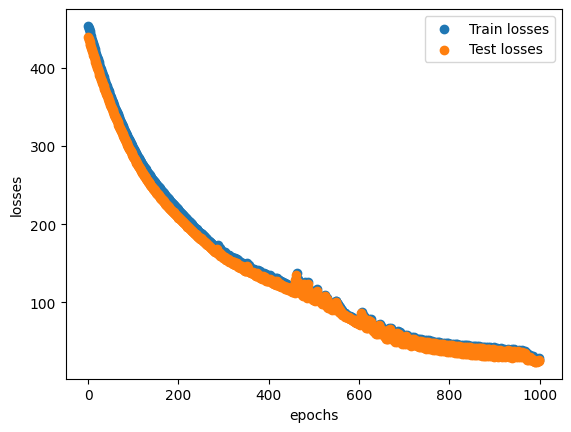

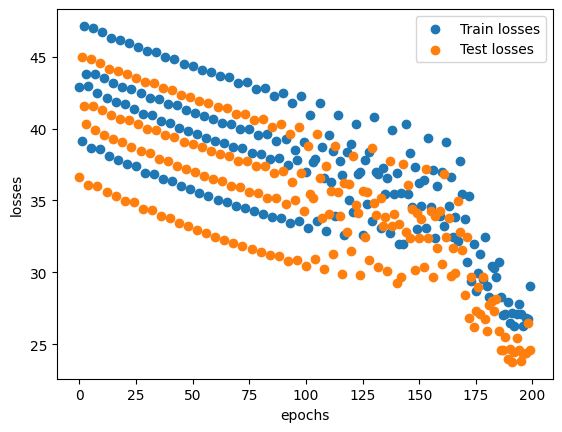

In [17]:
import matplotlib.pyplot as plt
plt.scatter(range(epochs), losses, label='Train losses')
plt.scatter(range(epochs), test_losses, label='Test losses')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()
plt.show()

split = int(epochs*0.2)

plt.scatter(range(split), losses[-split:], label='Train losses')
plt.scatter(range(split), test_losses[-split:], label='Test losses')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():  # Disable gradient tracking during inference
    for i, item in enumerate(x_test):
        y_pred = model(item.unsqueeze(0))  # Ensure item has batch dimension
        correct = y_test[i].item()

        print(f'expected: {correct}, guessed: {y_pred.item()}')

expected: -0.550000011920929, guessed: -170.10252380371094
expected: -0.4099999964237213, guessed: -140.00267028808594
expected: 3.200000047683716, guessed: 1149.7353515625
expected: -0.7699999809265137, guessed: 178.69386291503906
expected: 0.6399999856948853, guessed: 117.09474182128906
expected: -4.699999809265137, guessed: -357.576171875
expected: -0.4300000071525574, guessed: 37.2978630065918
expected: -0.28999999165534973, guessed: -106.88975524902344
expected: 14.300000190734863, guessed: 13.225597381591797
expected: -0.8999999761581421, guessed: 41.5952262878418
expected: -0.3700000047683716, guessed: 185.41944885253906
expected: -0.4000000059604645, guessed: 5.325206756591797
expected: 0.07000000029802322, guessed: 6.142589569091797
expected: -0.4099999964237213, guessed: 63.9482536315918
expected: -0.27000001072883606, guessed: -62.4623908996582
expected: 0.3400000035762787, guessed: 87.84767150878906
expected: 0.11999999731779099, guessed: -48.6232795715332
expected: -0.3000